<div style="
   background-color:#111827;   /* solid dark slate */
    padding: 28px;
    border-radius: 14px;
    color: #e5e7eb;
    margin-bottom: 30px;
    box-shadow: 0 10px 25px rgba(0,0,0,0.35);
">

<!-- PyTorch Logo -->
<div style="text-align:center; margin-bottom:16px;">
  <img 
    src="https://pytorch.org/assets/images/pytorch-logo.png"
    alt="PyTorch Logo"
    style="height:70px; opacity:0.95;"
  />
</div>

<h1 style="
    text-align: center;
    font-size: 34px;
    font-weight: 800;
    margin-bottom: 10px;
">
🔥 Transformers Made Easy
</h1>

<h3 style="
    text-align: center;
    font-weight: 500;
    color: #9ca3af;
    margin-top: 0;
">
Self-Attention & Multi-Head Attention from Scratch (PyTorch)
</h3>

<p style="
    text-align: center;
    max-width: 820px;
    margin: 18px auto;
    font-size: 16px;
    line-height: 1.6;
">
This notebook explains <b>Transformers from first principles</b>.
We build self-attention and multi-head attention <b>step by step</b>,
focusing on intuition, tensor shapes, and clean PyTorch implementation.
</p>

<hr style="border: 1px solid #1f2937; margin: 22px 0;">

<h3>📚 Table of Contents</h3>

<ol style="line-height: 1.9; padding-left: 18px;">
  <li><a href="#motivation--overview" style="color:#60a5fa;">Motivation & Overview</a></li>
  <li><a href="#why-attention-exists" style="color:#60a5fa;">Why Attention Exists</a></li>
  <li><a href="#Import-Libraries" style="color:#60a5fa;">Import Libraries</a></li>
  <li><a href="#input-embeddings--shapes" style="color:#60a5fa;">Input Embeddings & Shapes</a></li>
  <li><a href="#queries-keys-and-values" style="color:#60a5fa;">Queries, Keys, and Values(QKV)</a></li>
  <li><a href="#scaled-dot-product-attention" style="color:#60a5fa;">Scaled Dot-Product Attention</a></li>
  <li><a href="#self-attention-from-scratch" style="color:#60a5fa;">Visualizing Attention Weights</a></li>
  <li><a href="#Self-Attention Module" style="color:#60a5fa;">Self-Attention Module</a></li>
  <li><a href="#why-multi-head-attention" style="color:#60a5fa;">Why Multi-Head Attention</a></li>
  <li><a href="#Comparison with PyTorch Built-in Attention" style="color:#60a5fa;">Comparison with PyTorch Built-in Attention</a></li>
  <li><a href="#common-mistakes" style="color:#60a5fa;">Common Mistakes</a></li>
  <li><a href="#final-summary--next-steps" style="color:#60a5fa;">Final Summary & Next Steps</a></li>
</ol>

</div>


<div style="margin:34px 0 22px 0;">
  <h2 style="
      font-family: 'Inter', 'Segoe UI', Roboto, Arial, sans-serif;
      font-size:28px;
      font-weight:800;
      color:#93c5fd;          
      margin:0;
      letter-spacing:0.4px;
  ">
    1 | Motivation & Overview
  </h2>

  <hr style="
      border:none;
      height:1.5px;
      background: linear-gradient(to right, #3b82f6, #1f2937);
      margin-top:12px;
  ">
</div>


Transformers power modern AI systems like ChatGPT, BERT, and Vision Transformers —  
but **attention often feels like magic**.

In this notebook, we will:
- Build **self-attention step by step**
- Implement **multi-head attention from scratch**
- Track **every tensor shape**
- Visualize **attention weights**
- Compare with **PyTorch's built-in implementation**

🎯 Goal: *remove the black-box feeling of Transformers*

<div style="margin:34px 0 22px 0;">
  <h2 style="
      font-family: 'Inter', 'Segoe UI', Roboto, Arial, sans-serif;
      font-size:28px;
      font-weight:800;
      color: #93c5fd;        
      margin:0;
      letter-spacing:0.4px;
  ">
    2 | Why Attention Exists
  </h2>

  <hr style="
      border:none;
      height:1.5px;
      background: linear-gradient(to right, #3b82f6, #1f2937);
      margin-top:12px;
  ">
</div>

In language (and vision), **not all elements are equally important**.

Example sentence:
> *"The animal didn’t cross the street because **it** was tired."*

What does **"it"** refer to?

Attention allows each token to:
- Look at **all other tokens**
- Decide **how important they are**
- Build **context-aware representations**

This idea replaces recurrence and convolution in Transformers.

<div style="margin:34px 0 22px 0;">
  <h2 style="
      font-family: 'Inter', 'Segoe UI', Roboto, Arial, sans-serif;
      font-size:28px;
      font-weight:800;
      color: #93c5fd;        
      margin:0;
      letter-spacing:0.4px;
  ">
    3 | Import Libraries
  </h2>

  <hr style="
      border:none;
      height:1.5px;
      background: linear-gradient(to right, #3b82f6, #1f2937);
      margin-top:12px;
  ">
</div>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(42)

import matplotlib.pyplot as plt
import seaborn as sns

<div style="margin:34px 0 22px 0;">
  <h2 style="
      font-family: 'Inter', 'Segoe UI', Roboto, Arial, sans-serif;
      font-size:28px;
      font-weight:800;
      color: #93c5fd;        
      margin:0;
      letter-spacing:0.4px;
  ">
    4 | Input Embeddings & Shapes
  </h2>

  <hr style="
      border:none;
      height:1.5px;
      background: linear-gradient(to right, #3b82f6, #1f2937);
      margin-top:12px;
  ">
</div>

In [2]:
# toy example dimensions
batch_size = 2
seq_len = 4
d_model = 8

X = torch.randn(batch_size, seq_len, d_model)
X.shape

torch.Size([2, 4, 8])

### 📐 Tensor Shape
- Batch size = 2
- Sequence length = 4
- Embedding dimension = 8

Shape:
(batch, tokens, embedding)


<div style="margin:34px 0 22px 0;">
  <h2 style="
      font-family: 'Inter', 'Segoe UI', Roboto, Arial, sans-serif;
      font-size:28px;
      font-weight:800;
      color: #93c5fd;
      margin:0;
      letter-spacing:0.4px;
  ">
    5 | Query, Key, Value (OKV)
  </h2>

  <hr style="
      border:none;
      height:1.5px;
      background: linear-gradient(to right, #3b82f6, #1f2937);
      margin-top:12px;
  ">
</div>


Each token embedding is projected into:
- **Query (Q):** what this token is looking for
- **Key (K):** what this token offers
- **Value (V):** information carried by the token

These are learned **linear projections**.


In [3]:
W_q = nn.Linear(d_model, d_model)
W_k = nn.Linear(d_model, d_model)
W_v = nn.Linear(d_model, d_model)

Q = W_q(X)
K = W_k(X)
V = W_v(X)

Q.shape, K.shape, V.shape

(torch.Size([2, 4, 8]), torch.Size([2, 4, 8]), torch.Size([2, 4, 8]))

<div style="margin:34px 0 22px 0;">
  <h2 style="
      font-family: 'Inter', 'Segoe UI', Roboto, Arial, sans-serif;
      font-size:28px;
      font-weight:800;
      color: #93c5fd;        
      margin:0;
      letter-spacing:0.4px;
  ">
    6 | Scaled Dot-Product Attention
  </h2>

  <hr style="
      border:none;
      height:1.5px;
      background: linear-gradient(to right, #3b82f6, #1f2937);
      margin-top:12px;
  ">
</div>

The attention formula:

$$
\text{Attention}(Q, K, V)
= \text{softmax}\left(\frac{Q K^\top}{\sqrt{d_k}}\right) V
$$

- **Dot product** → similarity  
- **Scaling** → numerical stability  
- **Softmax** → importance weights  



In [4]:
scores = torch.matmul(Q, K.transpose(-2, -1))
scores = scores / (d_model ** 0.5)

attention_weights = F.softmax(scores, dim=-1)
output = torch.matmul(attention_weights, V)

output.shape


torch.Size([2, 4, 8])

<div style="margin:34px 0 22px 0;">
  <h2 style="
      font-family: 'Inter', 'Segoe UI', Roboto, Arial, sans-serif;
      font-size:28px;
      font-weight:800;
      color: #93c5fd;        
      margin:0;
      letter-spacing:0.4px;
  ">
    7 | Visualizing Attention Weights
  </h2>

  <hr style="
      border:none;
      height:1.5px;
      background: linear-gradient(to right, #3b82f6, #1f2937);
      margin-top:12px;
  ">
</div>

Attention becomes much clearer when we **see** it.
Below is the attention matrix for one sample.


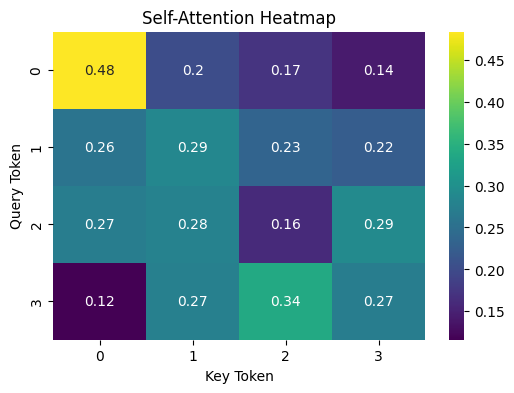

In [5]:
attn_example = attention_weights[0].detach().numpy()

plt.figure(figsize=(6, 4))
sns.heatmap(attn_example, annot=True, cmap="viridis")
plt.xlabel("Key Token")
plt.ylabel("Query Token")
plt.title("Self-Attention Heatmap")
plt.show()



<div style="margin:34px 0 22px 0;">
  <h2 style="
      font-family: 'Inter', 'Segoe UI', Roboto, Arial, sans-serif;
      font-size:28px;
      font-weight:800;
      color: #93c5fd;        
      margin:0;
      letter-spacing:0.4px;
  ">
    8 | Self-Attention Module
  </h2>

  <hr style="
      border:none;
      height:1.5px;
      background: linear-gradient(to right, #3b82f6, #1f2937);
      margin-top:12px;
  ">
</div>
Let’s wrap everything into a reusable PyTorch module.

In [6]:
class SelfAttention(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)

    def forward(self, X):
        Q = self.W_q(X)
        K = self.W_k(X)
        V = self.W_v(X)

        scores = torch.matmul(Q, K.transpose(-2, -1))
        scores = scores / (X.shape[-1] ** 0.5)

        attn = F.softmax(scores, dim=-1)
        return torch.matmul(attn, V)


### Test it:

In [7]:
sa = SelfAttention(d_model)
sa(X).shape


torch.Size([2, 4, 8])

<div style="margin:34px 0 22px 0;">
  <h2 style="
      font-family: 'Inter', 'Segoe UI', Roboto, Arial, sans-serif;
      font-size:28px;
      font-weight:800;
      color: #93c5fd;        
      margin:0;
      letter-spacing:0.4px;
  ">
    9 | Why Multi-Head Attention?
  </h2>

  <hr style="
      border:none;
      height:1.5px;
      background: linear-gradient(to right, #3b82f6, #1f2937);
      margin-top:12px;
  ">
</div>

A single attention head captures **one type of relationship**.

Multiple heads allow the model to:
- Focus on syntax
- Capture semantic meaning
- Learn long-range dependencies

Each head attends **independently**, then results are combined.


In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0

        self.num_heads = num_heads
        self.head_dim = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, X):
        B, T, D = X.shape

        Q = self.W_q(X)
        K = self.W_k(X)
        V = self.W_v(X)

        Q = Q.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1))
        scores = scores / (self.head_dim ** 0.5)

        attn = F.softmax(scores, dim=-1)
        out = torch.matmul(attn, V)

        out = out.transpose(1, 2).contiguous().view(B, T, D)
        return self.W_o(out)


### Test it

In [9]:
mha = MultiHeadAttention(d_model=8, num_heads=2)
mha(X).shape


torch.Size([2, 4, 8])

## Shape Flow Summary

| Step | Shape |
|----|----|
| Input | (B, T, D) |
| Q, K, V | (B, T, D) |
| Split Heads | (B, H, T, D/H) |
| Attention Scores | (B, H, T, T) |
| Output | (B, T, D) |



<div style="margin:34px 0 22px 0;">
  <h2 style="
      font-family: 'Inter', 'Segoe UI', Roboto, Arial, sans-serif;
      font-size:28px;
      font-weight:800;
      color: #93c5fd;        
      margin:0;
      letter-spacing:0.4px;
  ">
    10 | Comparison with PyTorch Built-in Attention
  </h2>

  <hr style="
      border:none;
      height:1.5px;
      background: linear-gradient(to right, #3b82f6, #1f2937);
      margin-top:12px;
  ">
</div>

In [10]:
torch_mha = nn.MultiheadAttention(embed_dim=8, num_heads=2, batch_first=True)
out_builtin, _ = torch_mha(X, X, X)

out_builtin.shape


torch.Size([2, 4, 8])

Both implementations follow the same principle.
PyTorch’s version is optimized for performance,
while our version prioritizes **clarity and learning**.


<div style="margin:34px 0 22px 0;">
  <h2 style="
      font-family: 'Inter', 'Segoe UI', Roboto, Arial, sans-serif;
      font-size:28px;
      font-weight:800;
      color: #93c5fd;        
      margin:0;
      letter-spacing:0.4px;
  ">
    11 | Common Mistakes
  </h2>

  <hr style="
      border:none;
      height:1.5px;
      background: linear-gradient(to right, #3b82f6, #1f2937);
      margin-top:12px;
  ">
</div>


Each head attends **independently**, then results are combined.


- Forgetting √dₖ scaling → unstable training
- Applying softmax on the wrong dimension
- Missing `.contiguous()` after transpose
- Confusing batch and head dimensions


<div style="margin:34px 0 22px 0;">
  <h2 style="
      font-family: 'Inter', 'Segoe UI', Roboto, Arial, sans-serif;
      font-size:28px;
      font-weight:800;
      color: #93c5fd;        
      margin:0;
      letter-spacing:0.4px;
  ">
    12 | Final Summary & Next Steps
  </h2>

  <hr style="
      border:none;
      height:1.5px;
      background: linear-gradient(to right, #3b82f6, #1f2937);
      margin-top:12px;
  ">
</div>

##  What We Learned

✔ Self-attention from scratch  
✔ Multi-head attention from scratch  
✔ Tensor shape intuition  
✔ Attention visualization  

### Next Steps
- Add attention masks
- Build a Transformer encoder block
- Apply attention to NLP or Vision tasks

If this notebook helped you understand attention,
**If this notebook saved you time or confusion, feel free to drop an upvote!⬆️**

